The purpose of this notebook is to show an example of the synthetic data experiment using one seed only.

## Initialize

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import torch
import copy 
import seaborn as sn
import random
import pandas as pd
import seaborn as sns
import numpy as np

import torch.nn as nn
import torch.optim as optim
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import sklearn
from sklearn.metrics import confusion_matrix
sys.path.append('../conformal_learning/third_party')
import pdb
from scipy.stats.mstats import mquantiles
  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available? {}".format(torch.cuda.is_available()))

sys.path.append('../')
from conformal_learning.bbox import BlackBox
from conformal_learning.split_conf import SplitConformal, evaluate_predictions, ProbAccum
from conformal_learning.auxiliary import eval_predictions, KL, cvm
from conformal_learning.data_gen import Model_Ex1, Oracle, difficulty_oracle

Is CUDA available? False


## Set the random seeds

In [2]:
seed = 20
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Sample the data

Sample train (for CE loss and new loss), test, hold-out and calibration sets using data_gen file.

In [3]:
p = 100                                                # Number of features
K = 6                                                  # Number of possible labels
delta_1 = 0.0
delta_2 = 0.2
a = 1

data_model = Model_Ex1(K,p,delta_1, delta_2,a)           # Data generating model

n_train = 2000                                         # Number of data samples
X_train = data_model.sample_X(n_train)                 # Generate the data features
Y_train = data_model.sample_Y(X_train)                 # Generate the data labels conditional on the features

n_tr_score = int(n_train*0.2)                          # Number of data samples for training the new loss
X_tr_score = data_model.sample_X(n_tr_score)           # Generate the data features
Y_tr_score = data_model.sample_Y(X_tr_score)           # Generate the data labels conditional on the features

n_hout = 2000                                         # Number of data samples
X_hout = data_model.sample_X(n_hout)
Y_hout = data_model.sample_Y(X_hout)

n_calib = 10000                                        # Number of test samples
X_calib = data_model.sample_X(n_calib)                 # Generate independent test data
Y_calib = data_model.sample_Y(X_calib)

n_test = 2000                                          # Number of test samples
X_test = data_model.sample_X(n_test, test=True)                   # Generate independent test data
Y_test = data_model.sample_Y(X_test)

# Name prefix of output files
out_prefix = 'delta_2_%a' %delta_2 + '_seed_%a' %seed

## Visualize the data distribution

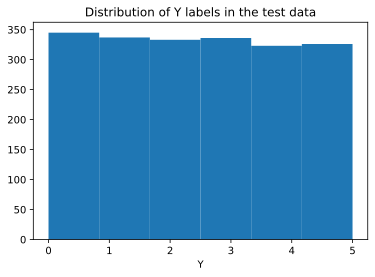

In [4]:
# Marginal distribution of Y
plt.hist(Y_test, bins=K)
plt.xlabel("Y")
plt.title("Distribution of Y labels in the test data")
plt.show()

Visualize the true probabilities of the test set for chosen labels.

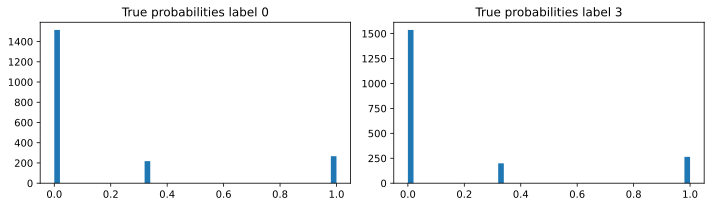

In [5]:
prob_true = data_model.compute_prob(X_test)

fig=plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
k = 0 # Which label to plot?
plt.hist(prob_true[:,k], bins=50, range=(0,1))
plt.title("True probabilities label " + str(k))
plt.subplot(1, 2, 2)
k = 3 # Which label to plot?
plt.hist(prob_true[:,k], bins=50, range=(0,1))
plt.title("True probabilities label " + str(k))
plt.tight_layout()
plt.show()

## Oracle diagnostics 

Here we plot the marginal distribution of oracle prediction set sizes and label-conditional distribution of oracle prediction set sizes.

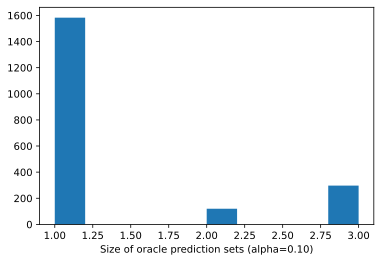

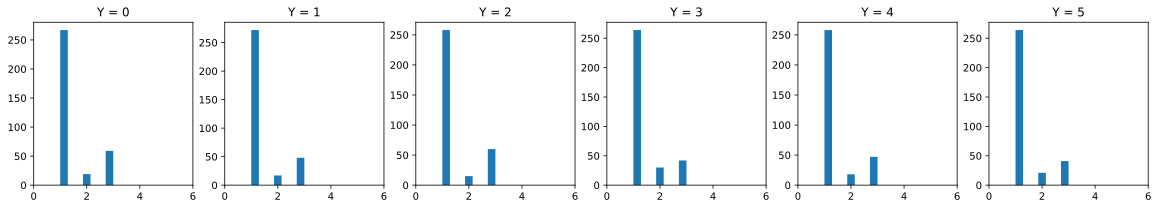

In [6]:
# Confidence level for the oracle
alpha = 0.1
 
oracle = Oracle(data_model)

# Find hard-to-classify samples (those samples for which the oracle needs larger sets)
sc_method = SplitConformal(bbox=oracle)
S_oracle = sc_method.predict(X_test, alpha=alpha)
size_oracle = np.array([len(S) for S in S_oracle])
easy_idx, hard_idx = difficulty_oracle(S_oracle)

# Plot the marginal distribution of oracle prediction set sizes
plt.hist(size_oracle)
plt.xlabel("Size of oracle prediction sets (alpha={:.2f})".format(alpha))
plt.show()

# Plot the label-conditional distribution of oracle prediction set sizes
fig=plt.figure(figsize=(20, 3))
for k in range(K):
    plt.subplot(1, K, 1+k)
    idx_k = np.where(Y_test==k)
    plt.hist(size_oracle[idx_k], bins=K+1)
    plt.xlim(0,K)
    plt.title("Y = {:d}".format(k))
plt.show()

Construct and evaluate conformal prediction sets based on the oracle

In [7]:
sc_method = SplitConformal()
sc_method.calibrate(X_calib, Y_calib, alpha, bbox=oracle)
sets = sc_method.predict(X_test)
res = evaluate_predictions(sets, X_test, Y_test, hard_idx, conditional=True)
res

Calibrated alpha nominal 0.100: 0.104


,Coverage,Conditional coverage,Size,Size (median),Size-hard,Size-easy,Size-hard (median),Size-easy (median),n-hard,n-easy,Size conditional on cover
0,0.977,0.889688,1.3585,1.0,2.719424,1.0,3.0,1.0,417,1583,1.343398


Compute and plot oracle conformity scores on test data for easy and hard samples.

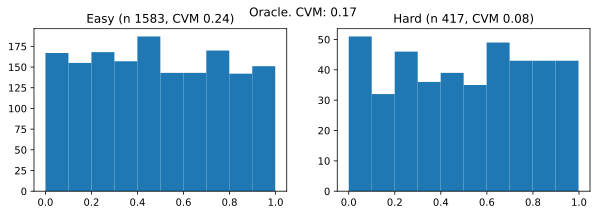

In [8]:
p_oracle_test = oracle.predict_proba(X_test)
grey_box = ProbAccum(p_oracle_test)
epsilon_test = np.random.uniform(size=(len(Y_test,)))
scores_test = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)

# Plot the distribution of oracle conformity scores on test data
fig=plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(scores_test[easy_idx])
plt.title("Easy (n {:d}, CVM {:.2f})".format(len(scores_test)-len(hard_idx), cvm(scores_test[easy_idx])))
plt.subplot(1, 2, 2)
plt.hist(scores_test[hard_idx])
plt.title("Hard (n {:d}, CVM {:.2f})".format(len(hard_idx), cvm(scores_test[hard_idx])))
plt.suptitle('Oracle. CVM: {:.2f}'.format(cvm(scores_test)))
plt.show()

# Train all models

Here we train the four different models or download pre-trained models from an existing directory (by setting refit_model to False). We also download the different models with early stopping.

Train model with CE loss

In [9]:
refit_model = False

num_features=X_train.shape[1]
num_classes = K
file_final = 'saved_models_synthetic/saved_model_orig_' + out_prefix

X_augmented = np.concatenate((X_train, X_tr_score),0)
Y_augmented = np.concatenate((Y_train, Y_tr_score),0)
        
if refit_model:
    box_ce = BlackBox(num_features, num_classes)
    stats_ce = box_ce.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, 
                          batch_size=200, num_epochs=3000, lr=0.01, mu=0, optimizer='SGD',
                          save_model=True, save_checkpoint_period = 1,
                          name=file_final, early_stopping=True, 
                          name_CP='saved_models_synthetic/checkpoint_orig_'+out_prefix)
else:
    print('Loading pre-trained model.')
    box_ce = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_ce.model.load_state_dict(saved_stats['model_state'])
    stats_ce = saved_stats['stats']

Loading pre-trained model.


In [10]:
# Download models with early stopping

# For early stopping loss
box_orig_ho_loss = BlackBox(num_features, num_classes)
saved_stats_ho_loss = torch.load('saved_models_synthetic/checkpoint_orig_'+out_prefix+'loss', map_location=device)
box_orig_ho_loss.model.load_state_dict(saved_stats_ho_loss['model_state'])

# For early stopping acc
box_orig_ho_acc = BlackBox(num_features, num_classes)
saved_stats_ho_acc = torch.load('saved_models_synthetic/checkpoint_orig_'+out_prefix+'acc', map_location=device)
box_orig_ho_acc.model.load_state_dict(saved_stats_ho_acc['model_state'])

<All keys matched successfully>

Train the new model

In [11]:
refit_model = False
file_final = 'saved_models_synthetic/saved_model_new_' + out_prefix

Z_train = np.zeros(len(Y_train))
Z_tr_score = np.ones(len(Y_tr_score))
Z_augmented = np.concatenate((Z_train, Z_tr_score),0)


if refit_model:
    
    box_new = BlackBox(num_features, num_classes)
    stats_new = box_new.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout,
                                Z_train=Z_augmented,
                                batch_size=750, num_epochs=4000, lr=0.001,
                                mu=0.2, mu_size=0, alpha=0.1, 
                                save_model=True, save_checkpoint_period = 1,
                                name=file_final, early_stopping=True, 
                                name_CP='saved_models_synthetic/checkpoint_new_cs_'+out_prefix)

else:
    print('Loading pre-trained model.')
    box_new = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_new.model.load_state_dict(saved_stats['model_state'])
    stats_new = saved_stats['stats']

Loading pre-trained model.


In [12]:
# Download models with early stopping

# For early stopping loss
box_new_ho_loss = BlackBox(num_features, num_classes)
saved_stats_new_loss = torch.load('saved_models_synthetic/checkpoint_new_cs_'+out_prefix+'loss', map_location=device)
box_new_ho_loss.model.load_state_dict(saved_stats_new_loss['model_state'])

# For early stopping acc
box_new_ho_acc = BlackBox(num_features, num_classes)
saved_stats_new_acc = torch.load('saved_models_synthetic/checkpoint_new_cs_'+out_prefix+'acc', map_location=device)
box_new_ho_acc.model.load_state_dict(saved_stats_new_acc['model_state'])

<All keys matched successfully>

Train the hybrid model

In [13]:
file_final = 'saved_models_delta_2/saved_model_hybrid_' + out_prefix
refit_model = False

if refit_model:
    box_hybrid = BlackBox(num_features, num_classes)
    stats_hybrid = box_hybrid.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout,
                                Z_train=Z_augmented,
                                batch_size=750, num_epochs=4000, lr=0.01,
                                mu=0, mu_size=0.2, alpha=0.1,  optimizer='SGD',
                                save_model=True, save_checkpoint_period = 1,
                                name=file_final, early_stopping=True, 
                                name_CP='saved_models_synthetic/checkpoint_hybrid_'+out_prefix, verbose=True)

else:
    print('Loading pre-trained model.')
    box_hybrid = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_hybrid.model.load_state_dict(saved_stats['model_state'])
    stats_hybrid = saved_stats['stats']

Loading pre-trained model.


In [14]:
# Download models with early stopping

# For early stopping loss
box_hybrid_ho_loss = BlackBox(num_features, num_classes)
saved_stats_hybrid_loss = torch.load('saved_models_synthetic/checkpoint_hybrid_'+out_prefix+'loss', map_location=device)
box_hybrid_ho_loss.model.load_state_dict(saved_stats_hybrid_loss['model_state'])

# For early stopping acc
box_hybrid_ho_acc = BlackBox(num_features, num_classes)
saved_stats_hybrid_acc = torch.load('saved_models_synthetic/checkpoint_hybrid_'+out_prefix+'acc', map_location=device)
box_hybrid_ho_acc.model.load_state_dict(saved_stats_hybrid_acc['model_state'])

<All keys matched successfully>

Train model with focal loss

In [15]:
file_final = 'saved_models_synthetic/saved_model_FocalLoss_' + out_prefix
refit_model = False

if refit_model:
    box_fc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1) # gamma 0 same as C.E.
    stats_fc = box_fc.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, 
                          batch_size=200, mu=0, num_epochs=3000, lr=0.01, optimizer='SGD',
                          save_model=True, save_checkpoint_period = 1,
                          name=file_final, early_stopping=True, name_CP='saved_models_synthetic/checkpoint_FocalLoss_'+out_prefix, verbose=True) 

else:
    print('Loading pre-trained model.')
    box_fc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
    saved_stats = torch.load(file_final, map_location=device)
    box_fc.model.load_state_dict(saved_stats['model_state'])
    stats_fc = saved_stats['stats']

Loading pre-trained model.


In [16]:
# Download models with early stopping

# For early stopping loss
box_focal_ho_loss = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
saved_stats_ho_loss = torch.load('saved_models_synthetic/checkpoint_FocalLoss_'+out_prefix+'loss', map_location=device)
box_focal_ho_loss.model.load_state_dict(saved_stats_ho_loss['model_state'])

# For early stopping acc
box_focal_ho_acc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
saved_stats_ho_acc = torch.load('saved_models_synthetic/checkpoint_FocalLoss_'+out_prefix+'acc', map_location=device)
box_focal_ho_acc.model.load_state_dict(saved_stats_ho_acc['model_state'])

<All keys matched successfully>

## Training diagnostics

Here we plot some training diagnostics such as accuracy and different loss functions.

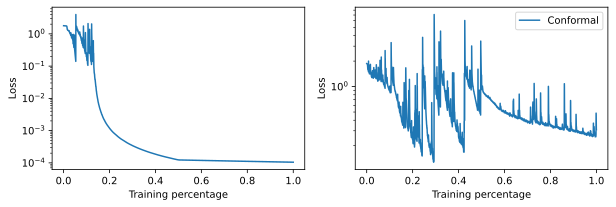

In [17]:
# Graph of the loss function computed on the training set

fig=plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["loss"], label="Cross-entropy")
plt.xlabel("Training percentage")
plt.ylabel("Loss")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["loss"], label="Conformal")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Loss")
plt.yscale("log")

plt.show()

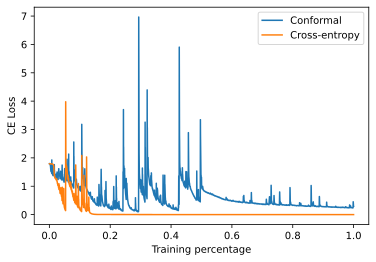

In [18]:
# Graph of CE loss computed on the training set

plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["pred"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["pred"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("CE Loss")
#plt.yscale("log")
plt.show()

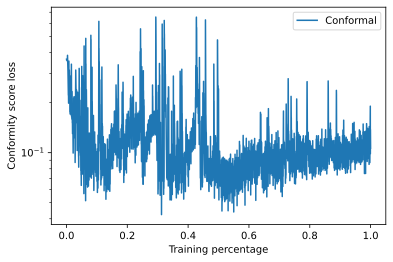

In [19]:
# Graph of the new conformity score loss function computed on the training set

plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["scores"], label="Conformal")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Conformity score loss")
plt.yscale("log")
plt.show()

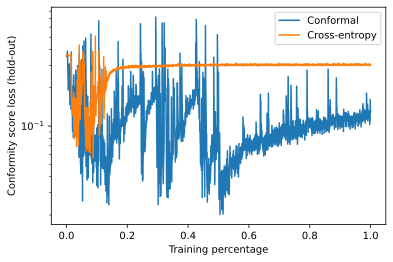

In [21]:
# Graph of the new conformity score loss function computed on the hold-out set

plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["scores-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["scores-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Conformity score loss (hold-out)")
plt.yscale('log')
plt.show()

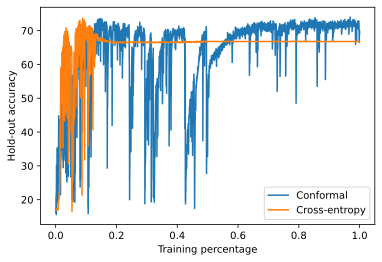

In [22]:
# Graph of the accuracy computed on the hold-out set

plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["acc-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["acc-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Hold-out accuracy")
plt.show()

# Check results

## Predictive accuracy

In [23]:
eval_predictions(X_test, Y_test, oracle, data="test (oracle)")
eval_predictions(X_test, Y_test, box_ce, data="test (CE)")
eval_predictions(X_test, Y_test, box_new, data="test (Conformal)")

Classification error on test (oracle) data: 13.8%
Classification error on test (CE) data: 32.9%
Classification error on test (Conformal) data: 31.3%


31.3

In [24]:
# Find hard-to-classify samples (those samples for which the oracle needs larger sets)
eval_predictions(X_test[hard_idx], Y_test[hard_idx], oracle, data="test (oracle, hard)")
eval_predictions(X_test[hard_idx], Y_test[hard_idx], box_ce, data="test (CE, hard)")
eval_predictions(X_test[hard_idx], Y_test[hard_idx], box_new, data="test (Conformal, hard)")

print("")
eval_predictions(X_test[easy_idx], Y_test[easy_idx], oracle, data="test (oracle, easy)")
eval_predictions(X_test[easy_idx], Y_test[easy_idx], box_ce, data="test (CE, easy)")
eval_predictions(X_test[easy_idx], Y_test[easy_idx], box_new, data="test (Conformal, easy)")
print("")

Classification error on test (oracle, hard) data: 66.2%
Classification error on test (CE, hard) data: 73.4%
Classification error on test (Conformal, hard) data: 77.5%

Classification error on test (oracle, easy) data: 0.0%
Classification error on test (CE, easy) data: 22.2%
Classification error on test (Conformal, easy) data: 19.1%



## Estimated conditional distribution

Here we plot the conditional distribution of different models.

In [25]:
black_boxes = [oracle, box_ce, box_new, box_orig_ho_acc, box_new_ho_acc]
black_boxes_names = ["Oracle", "Cross-entropy", "Conformal",
                     "Cross-entropy ES acc", "Conformal ES acc"]

probs = [bbox.predict_proba(X_test) for bbox in black_boxes]

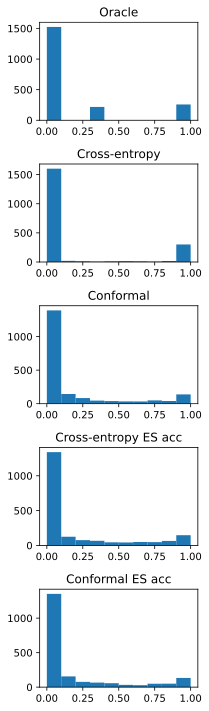

In [26]:
k_list = [2] # Which label to plot?

n_plots = len(probs)
fig=plt.figure(figsize=(len(k_list)*3, 10))
for i in range(n_plots):
    for j in range(len(k_list)):
        k = k_list[j]
        plt.subplot(n_plots*len(k_list), len(k_list), 1+i*len(k_list)+j)
        plt.hist(probs[i][:,k], bins=10, range=(0,1))
        plt.title(black_boxes_names[i])
plt.tight_layout()
plt.show()

## Conformity scores on test data

Plot the conformity scores of different models and compute the cvm.

Plotting conformity scores for Cross-Entropy model.


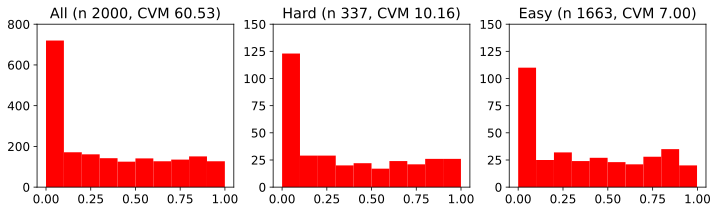

Plotting conformity scores for Conformal model.


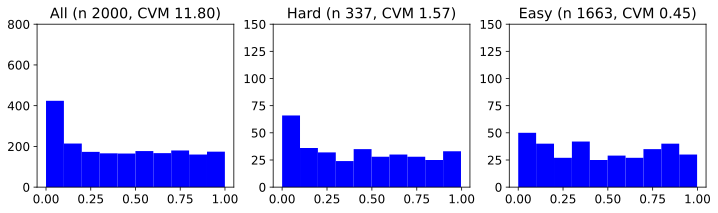

In [27]:
for plot_model in ["Cross-Entropy", "Conformal"]:

    if plot_model == "Cross-Entropy":
        bbox_plot = box_ce      # choose bbox to plot histogram of scores
        color = "red"
    elif plot_model == "Conformal":
        bbox_plot = box_new
        color = "blue"
    elif plot_model == "Focal":
        bbox_plot = box_fc 
        color = "yellow"
    elif plot_model == "Hybrid":
        bbox_plot = box_hybrid 
        color = "black"
        
    print("Plotting conformity scores for {:s} model.".format(plot_model))

    p_hat_test = bbox_plot.predict_proba(X_test)
    grey_box = ProbAccum(p_hat_test)
    epsilon_test = np.random.uniform(size=(len(Y_test,)))
    scores_test = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)

    easy_idx = np.asarray(np.where((Y_test==0)))[0,:]
    hard_idx = np.asarray(np.where((Y_test==1)))[0,:]

    fig=plt.figure(figsize=(12, 3))
    plt.rcParams['font.size'] = '12'
    plt.subplot(1, 3, 1)
    plt.hist(scores_test, color=color)
    plt.ylim([0,800])
    plt.title("All (n {:d}, CVM {:.2f})".format(len(scores_test), cvm(scores_test)))

    plt.subplot(1, 3, 2)
    plt.hist(scores_test[hard_idx], color=color)
    plt.ylim([0,150])
    plt.title("Hard (n {:d}, CVM {:.2f})".format(len(hard_idx), cvm(scores_test[hard_idx])))

    plt.subplot(1, 3, 3)
    plt.hist(scores_test[easy_idx], color=color)
    plt.ylim([0,150])
    plt.title("Easy (n {:d}, CVM {:.2f})".format(len(scores_test)-len(hard_idx), cvm(scores_test[easy_idx])))
    plt.show()

## Split-conformal (evaluate)

Show the conditional coverage, sizes and other results using split-conformal.

In [28]:
black_boxes = [oracle, box_ce, box_orig_ho_loss, box_orig_ho_acc, 
                box_new, box_new_ho_loss, box_new_ho_acc,
                box_hybrid, box_hybrid_ho_loss, box_hybrid_ho_acc,
                box_fc, box_focal_ho_loss, box_focal_ho_acc]
black_boxes_names = ["Oracle", 
                       "Cross-entropy", "Cross-entropy ES loss", "Cross-entropy ES acc",
                       "Conformal", "Conformal ES loss", "Conformal ES acc",
                       "Hybrid", "Hybrid ES loss", "Hybrid ES acc",
                       "Focal", "Focal ES loss", "Focal ES acc"]


colors = ["amber", "red", "red", "red", "blue", "blue","blue", "black", "black", "black", "yellow", "yellow", "yellow"]

In [29]:
alpha = 0.1

n_calib = 10000                                     # Number of calibration samples
X_calib = data_model.sample_X(n_calib)             # Generate independent calibration data
Y_calib = data_model.sample_Y(X_calib)

sc_methods = []
for i in range(len(black_boxes)):
    print("{:s}:".format(black_boxes_names[i]))
    sc_method = SplitConformal()
    sc_method.calibrate(X_calib, Y_calib, alpha, bbox=black_boxes[i])
    sc_methods.append(sc_method)

Oracle:
Calibrated alpha nominal 0.100: 0.099
Cross-entropy:
Calibrated alpha nominal 0.100: 0.000
Cross-entropy ES loss:
Calibrated alpha nominal 0.100: 0.090
Cross-entropy ES acc:
Calibrated alpha nominal 0.100: 0.061
Conformal:
Calibrated alpha nominal 0.100: 0.026
Conformal ES loss:
Calibrated alpha nominal 0.100: 0.065
Conformal ES acc:
Calibrated alpha nominal 0.100: 0.039
Hybrid:
Calibrated alpha nominal 0.100: 0.000
Hybrid ES loss:
Calibrated alpha nominal 0.100: 0.063
Hybrid ES acc:
Calibrated alpha nominal 0.100: 0.090
Focal:
Calibrated alpha nominal 0.100: 0.000
Focal ES loss:
Calibrated alpha nominal 0.100: 0.079
Focal ES acc:
Calibrated alpha nominal 0.100: 0.092


In [30]:
results = pd.DataFrame()
results_full = pd.DataFrame()

from tqdm.notebook import tqdm

sc_method_oracle = SplitConformal(bbox=oracle)

for e in tqdm(range(30)):

    n_test = 2000                                          # Number of test samples
    X_test = data_model.sample_X(n_test)                   # Generate independent test data
    Y_test = data_model.sample_Y(X_test)

    S_oracle = sc_method_oracle.predict(X_test, alpha=alpha)
    size_oracle = np.array([len(S) for S in S_oracle])
    easy_idx, hard_idx = difficulty_oracle(S_oracle)

    for k in range(len(black_boxes)):
        sets = sc_methods[k].predict(X_test)
        res = evaluate_predictions(sets, X_test, Y_test, hard_idx, conditional=True)

        res['Model'] = black_boxes_names[k]
        res['Experiment'] = e

        sizes = [len(S) for S in sets]
        coverages = [Y_test[i] in sets[i] for i in range(len(Y_test))]
        res_full = pd.DataFrame({'Y':Y_test, 'Size':sizes, 'Coverage':coverages, 'Difficulty':size_oracle})
        res_full['Model'] = black_boxes_names[k]
        res_full['Experiment'] = e

        results = pd.concat([results, res])
    results_full = pd.concat([results_full, res_full])

  0%|          | 0/30 [00:00<?, ?it/s]

In [31]:
results.groupby(['Model']).mean()

,Coverage,Conditional coverage,Size,Size (median),Size-hard,Size-easy,Size-hard (median),Size-easy (median),n-hard,n-easy,Size conditional on cover,Experiment
Model,,,,,,,,,,,,
Conformal,0.904983,0.737772,1.994600,2.0,3.339861,1.655020,3.000000,1.05,403.1,1596.9,2.000254,14.5
Conformal ES acc,0.903650,0.723939,1.916967,2.0,3.202530,1.592505,3.000000,1.00,403.1,1596.9,1.908404,14.5
Conformal ES loss,0.911917,0.726527,1.978800,2.0,3.599790,1.569491,3.983333,1.00,403.1,1596.9,1.960895,14.5
Cross-entropy,0.903383,0.683761,2.394717,2.0,3.132556,2.208479,3.000000,2.00,403.1,1596.9,2.387599,14.5
Cross-entropy ES acc,0.907117,0.658358,1.839850,2.0,3.051841,1.533881,3.000000,1.00,403.1,1596.9,1.814299,14.5
Cross-entropy ES loss,0.911517,0.694817,1.930233,2.0,3.192260,1.611650,3.000000,1.00,403.1,1596.9,1.903754,14.5
Focal,0.896100,0.633967,2.123200,2.0,3.009395,1.899462,3.000000,2.00,403.1,1596.9,2.091636,14.5
Focal ES acc,0.905183,0.663628,2.148567,2.0,3.328739,1.850782,3.033333,2.00,403.1,1596.9,2.113854,14.5
Focal ES loss,0.906467,0.694330,2.072467,2.0,3.283488,1.766761,3.000000,2.00,403.1,1596.9,2.039410,14.5


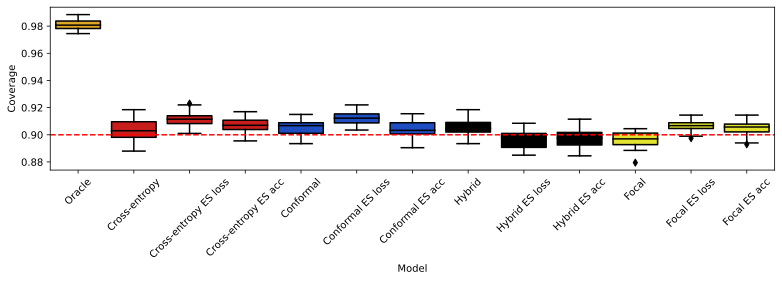

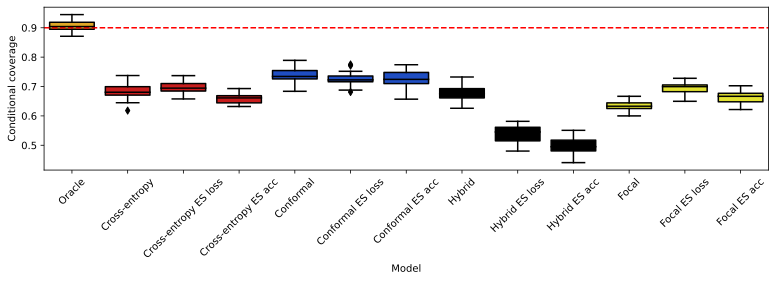

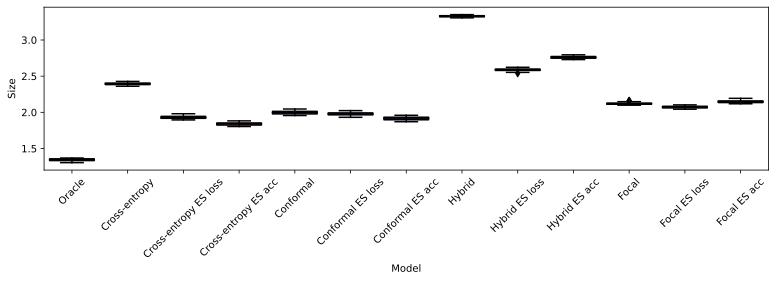

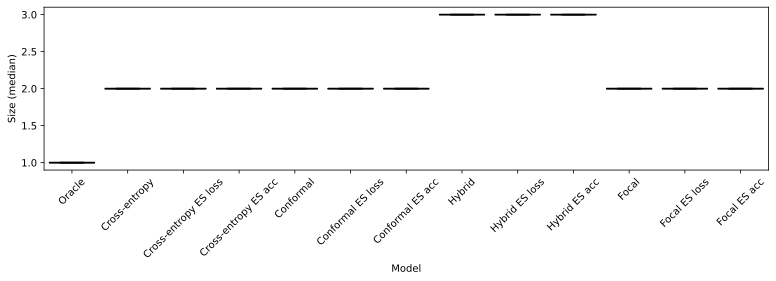

In [32]:
sn.reset_orig()
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Conditional coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Size')
g.set_xticklabels(black_boxes_names, rotation=45)
#plt.ylim(0.5,2)
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Size (median)')
g.set_xticklabels(black_boxes_names, rotation=45)
#plt.ylim(0.5,2)
plt.show()